# 6.5.1 Best Subset Selection

In [7]:
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')


In this lab we apply the best subset selection approach to the Boston data set. We wish to predict medv (median
house value) using 13 predictors such as rm (average number of rooms per house), age (average age of houses), and lstat (percent of households with low socioeconomic status). The Boston data set was also used to explore linear regression in lab 3.6.2 and 3.6.3.


In [10]:
boston = pd.read_csv('DataSets/Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [11]:
print(boston.shape)

(506, 14)


In [20]:
y = boston.medv
# Drop the column with the independent variable (Salary), and remove dummy variables
X = boston.drop(['medv', 'chas'], axis=1).astype('float64')

Best subset selection can be performed by identifying the best model that contains a given number of predictors, where best is quantified using RSS. We need to define a helper function that outputs the best set of variables for each model size:

In [21]:
# This function fits the model on feature_set and calculates RSS
def processSubset(feature_set):
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [22]:
def getBest(k):

    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))

    models = pd.DataFrame(results)
    
    # Choose the model with the smallest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model
    return best_model

This returns a DataFrame containing the best model that we generated, along with some extra information
about the model. Next, we will call that function for each number of predictors k:

In [34]:
models = pd.DataFrame(columns=["RSS", "model"])

for i in range(1,10):
    models.loc[i] = getBest(i)


The DataFrame models contains contains the best models we’ve generated. Let’s take a look at the first few:

In [35]:
models

,RSS,model
1,29555.781529,<statsmodels.regression.linear_model.Regressio...
2,15444.934439,<statsmodels.regression.linear_model.Regressio...
3,14343.626020,<statsmodels.regression.linear_model.Regressio...
4,13555.583004,<statsmodels.regression.linear_model.Regressio...
5,13161.006084,<statsmodels.regression.linear_model.Regressio...
6,12977.584635,<statsmodels.regression.linear_model.Regressio...
7,12796.642715,<statsmodels.regression.linear_model.Regressio...
8,12693.779151,<statsmodels.regression.linear_model.Regressio...
9,12494.674310,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, we can get a full rundown of a single model
using the summary() function. The summary() function also returns R2, RSS, adjusted R2, Cp, AIC, and BIC.
We can examine these to try to select the best overall model.

In [36]:
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     4637.
Date:                Tue, 09 May 2017   Prob (F-statistic):               0.00
Time:                        00:37:52   Log-Likelihood:                -1582.9
No. Observations:                 506   AIC:                             3170.
Df Residuals:                     504   BIC:                             3178.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
rm             4.9069      0.070     69.906      0.0

This output indicates that the best two-variable model contains only rm (average number of rooms per dwelling) and lstat (lower status of the population).

Rather than letting the results of our call to the summary() function print to the screen, we can access
just the parts we need using the model’s attributes. For example, if we want the R2 value:

In [37]:
models.loc[2, "model"].rsquared

0.9484526812988413

In addition to the verbose output we get when we print the summary to the screen, fitting the OLM also produced many other useful statistics such as adjusted R2, AIC, and BIC. We can examine these to try to select the best overall model. Let’s start by looking at R2 across all our models:

In [38]:
# Gets the second element from each row (’model’) and pulls out its rsquared attribute
models.apply(lambda row: row[1].rsquared, axis=1)

1    0.901358
2    0.948453
3    0.952128
4    0.954758
5    0.956075
6    0.956687
7    0.957291
8    0.957635
9    0.958299
dtype: float64

 As expected, the R2 statistic increases monotonically as more variables are included. We see that the R2 statistic increases from 0.901, when only one variable is included in the model, to 0.958, when all variables are included.

Plotting RSS, adjusted R2, Cp, and BIC for all of the models at once will help us decide which model to select. We plot a red dot to indicate the models with the largest adjusted R2 statistic, and smalles AIC, BIC and RSS statistics.

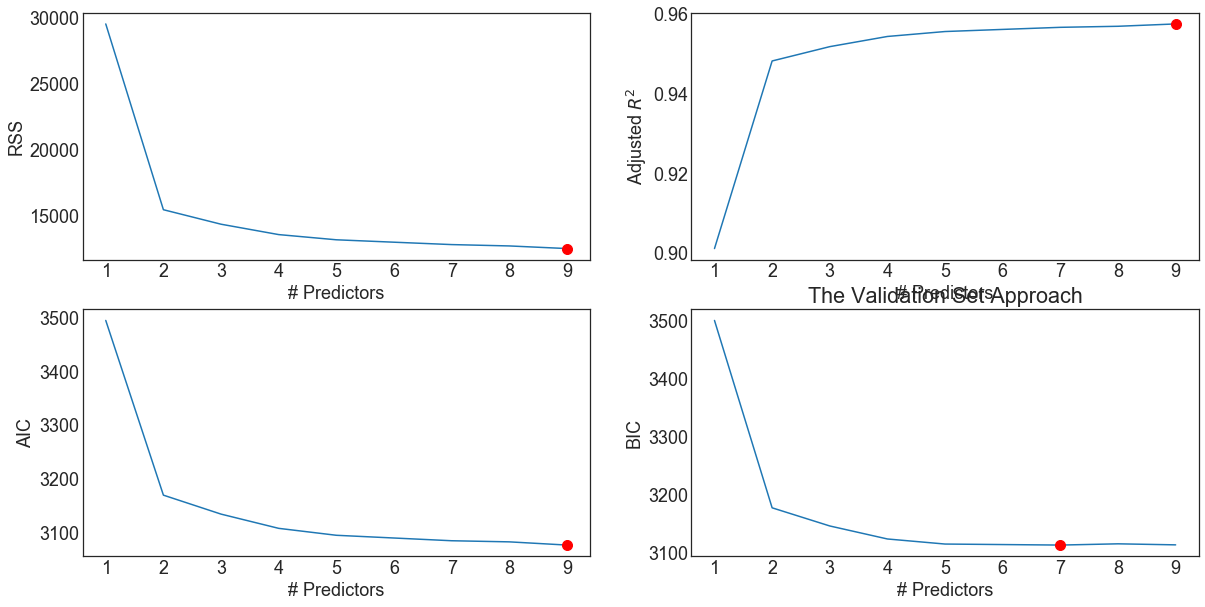

In [39]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)

plt.plot(models["RSS"])
plt.plot(models["RSS"].argmin(), models["RSS"].min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('RSS')


rsquared = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared)
plt.plot(rsquared.argmax(), rsquared.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Adjusted $R^2$')



aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')



bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')
plt.title('The Validation Set Approach')
plt.savefig('validationSet.png', dpi=200)


In the second step of the selection process, we narrowed the field down to just one model on any $k \le p$ predictors. We see that several models share a BIC close to 3100. However, the model with the lowest BIC is the seven-variable model that contains only crim, zn, rm, dis, ptratio, lstat, and black. Therefore, according to BIC, the best performer is the model with 7 variables. According to AIC and adjusted R2 something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture but they all agree that a model with only one predictor is insufficient.

In [40]:
print(models.loc[7, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1598.
Date:                Tue, 09 May 2017   Prob (F-statistic):               0.00
Time:                        00:39:16   Log-Likelihood:                -1535.3
No. Observations:                 506   AIC:                             3085.
Df Residuals:                     499   BIC:                             3114.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
crim          -0.0841      0.032     -2.656      0.0